# Public Sentiment Analysis using Naive Bayes

In this micro project, we will work with DKI Jakarta resident tweets data set about Indonesia capital city transfer to Penajam Paser Utara, East Kalimantan. As this is a supervised classification case, a Naive Bayes model is well suited here. We will build a Naive Bayes model to predict / classify which tweet has positive sentiment and which tweet has negative sentiment. The purpose of this micro project is to answer 2 questions:
1. Does DKI Jakarta resident agree or disagree to transfer the capital city to Penajam Paser Utara, East Kalimantan?
2. What is the reason or cause of their agreement / disagreement?

The data used in this micro project are acquired from web scraping using Twitter API.

In [1]:
import json, tweepy, re, string, tqdm
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from nltk.probability import FreqDist
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import ClippedCorpus
from pprint import pprint
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Data Collection

#### Web Scraping - Twitter API

Token, authentication and API variable preparation. I named the token "token.json".

In [2]:
with open("token.json")as f:
    tokens = json.load(f)

bearer_token = tokens["bearer_token"]
api_key = tokens["api_key"]
api_key_secret = tokens["api_key_secret"]
access_token = tokens["access_token"]
access_token_secret = tokens["access_token_secret"]

auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

Define request parameter variables.

In [3]:
keyword = "ibu kota negara"
until_date = "2022-01-27"                # last search date
location = "-6.203013,106.846634,30km"   # search location coordinate and the radius
max_result = 300

Make request to Twitter API.

In [4]:
query = keyword + " -is:retweet"   # filtering retweet
tweets = tweepy.Cursor(api.search_tweets,
                       q=query,
                       geocode=location,
                       lang="id",
                       until=until_date
                      ).items(max_result)

Save request/scrape result to a Dataframe.

In [5]:
items = []
for tweet in tweets:
    items.append([tweet.created_at, tweet.text])

df = pd.DataFrame(data=items, columns=["Created At", "Tweet"])
df

,Created At,Tweet
0,2022-01-26 23:56:45+00:00,Gak kredibel tapi jadi menteri. \nMakin memper...
1,2022-01-26 23:30:27+00:00,"@democrazymedia Woi, ibu kota itu salah 1 bag..."
2,2022-01-26 22:47:31+00:00,Kantor Staf Presiden (KSP) memastikan skema pe...
3,2022-01-26 22:01:40+00:00,Pembangunan ibu kota negara (IKN0 membawa manf...
4,2022-01-26 22:01:39+00:00,Pembangunan ibu kota negara (IKN0 membawa manf...
...,...,...
295,2022-01-23 03:28:46+00:00,"Ibu Kota Negara Pindah ke Kaltim, Anies Yakin ..."
296,2022-01-23 03:22:56+00:00,5 Negara Ini Dinilai Gagal Memindahkan Ibu Kot...
297,2022-01-23 03:00:08+00:00,"UU Ibu Kota Negara Bisa Dibatalkan MK, Ini Ala..."
298,2022-01-23 02:56:05+00:00,"Disahkan DPR, Faisal Basri akan Gugat UU Ibu K..."


For model training, we already have classified data set. Let's load it.

In [5]:
df_train = pd.read_csv("dataset_komentar_instagram_cyberbullying.csv")
df_train.rename(columns={"Instagram Comment Text":"Teks"}, inplace=True)
df_train.drop(columns=["Id"], inplace=True)
df_train.head()

,Sentiment,Teks
0,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


## Data Preparation

#### Text Preprocessing

Define text preprocessing functions:
- Case folding, used to convert text to lowercase and remove numbers, special characters, and punctuation.
- Slang cleaner, used to standardize slang words and remove inappropriate words (harsh, dirty, etc.).
- Stopword cleaner, used to remove common words.

In [2]:
def case_folding(data):
    data = data.lower()
    data = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", data).split())
    data = re.sub(r"\d+", "", data)
    data = data.translate(str.maketrans("", "", string.punctuation))
    data = re.sub(r"\n", "", data)
    data = re.sub(r"\t", "", data)
    return data

def slang_cleaner(data, slang_list):
    word_token = word_tokenize(data)
    slang_list.fillna("", inplace=True)
    slang_list = list(slang_list.itertuples(index=False, name=None))
    word_list = []
    for word in word_token:
        for slang in slang_list:
            if word in slang[0].lower():
                word = slang[1]
                break
        word_list.append(word)
    data = " ".join(word_list)
    return data

def stopword_cleaner(data, exclude):
    word_token = word_tokenize(data)
    sw_indo = stopwords.words("indonesian")
    sw_indo = [word for word in sw_indo if word not in exclude]
    data  = [word for word in word_token if word not in sw_indo]
    data = ' '.join(data)
    return data

Load slang words and create list of words to be excluded, so the sentiment analysis result could be reliable.

In [3]:
slang_list = pd.read_csv("Kata_Slang_Indo_220129.csv", header=None)

exclude = ["anti", "bagus", "belum", "benar", "betul", "bukan", "jangan", "jelek", "mudah", "salah", "sesuai", "setuju",
           "sudah", "sulit", "susah", "tidak"]

Now we preprocess our data set.

In [11]:
df["Tweet_bersih"] = ""
df["Tweet_bersih"] = df["Tweet"].apply(lambda item: case_folding(item))
df["Tweet_bersih"] = df["Tweet_bersih"].apply(lambda item: slang_cleaner(item, slang_list))
df["Tweet_bersih"] = df["Tweet_bersih"].apply(lambda item: stopword_cleaner(item, exclude))
df

,Created At,Tweet,Tweet_bersih
0,2022-01-26 23:56:45+00:00,Gak kredibel tapi jadi menteri. \nMakin memper...,tidak kredibel menteri memperburuk citra pemer...
1,2022-01-26 23:30:27+00:00,"@democrazymedia Woi, ibu kota itu salah 1 bag...",kota salah negara tidak diumbar pembangunannya...
2,2022-01-26 22:47:31+00:00,Kantor Staf Presiden (KSP) memastikan skema pe...,kantor staf presiden ksp skema pembiayaan pemb...
3,2022-01-26 22:01:40+00:00,Pembangunan ibu kota negara (IKN0 membawa manf...,pembangunan kota negara ikn membawa manfaat pe...
4,2022-01-26 22:01:39+00:00,Pembangunan ibu kota negara (IKN0 membawa manf...,pembangunan kota negara ikn membawa manfaat pe...
...,...,...,...
295,2022-01-23 03:28:46+00:00,"Ibu Kota Negara Pindah ke Kaltim, Anies Yakin ...",kota negara pindah kaltim anies jakarta pusat ...
296,2022-01-23 03:22:56+00:00,5 Negara Ini Dinilai Gagal Memindahkan Ibu Kot...,negara dinilai gagal memindahkan kota pegawain...
297,2022-01-23 03:00:08+00:00,"UU Ibu Kota Negara Bisa Dibatalkan MK, Ini Ala...",uu kota negara dibatalkan mk alasannya
298,2022-01-23 02:56:05+00:00,"Disahkan DPR, Faisal Basri akan Gugat UU Ibu K...",disahkan dpr faisal basri gugat uu kota negara mk


Plot the most frequent words in the data set to check whether the unuseful words still exist.

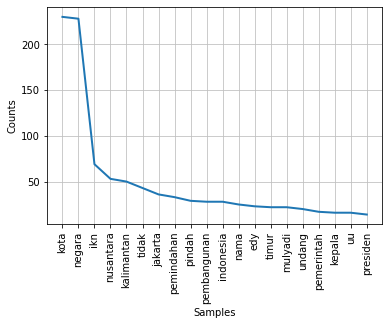

In [12]:
df_plot = df.copy()
df_plot["Tweet_bersih"] = df_plot["Tweet_bersih"].apply(lambda item: word_tokenize(str(item)))
text = [word for tweet in df_plot["Tweet_bersih"] for word in tweet]

fqdist = FreqDist(text)
most_common_word = fqdist.most_common(20)
fqdist.plot(20, cumulative=False);   # show 20 most frequent words

Do not forget to preprocess our training data set too.

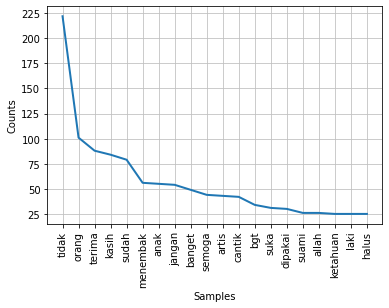

In [6]:
df_train["Teks_bersih"] = ""
df_train["Teks_bersih"] = df_train["Teks"].apply(lambda item: case_folding(item))
df_train["Teks_bersih"] = df_train["Teks_bersih"].apply(lambda item: slang_cleaner(item, slang_list))
df_train["Teks_bersih"] = df_train["Teks_bersih"].apply(lambda item: stopword_cleaner(item, exclude))

df_train_plot = df_train.copy()
df_train_plot["Teks_bersih"] = df_train_plot["Teks_bersih"].apply(lambda item: word_tokenize(str(item)))
text_train = [word for tweet in df_train_plot["Teks_bersih"] for word in tweet]

fqdist_train = FreqDist(text_train)
most_common_word_train = fqdist_train.most_common(20)
fqdist_train.plot(20, cumulative=False);

Based on the plot result, the most frequent words in both data set is unique/uncommon words, hence the data set is ready to be modelled.

Export our data to CSV file for backup.

In [13]:
df.to_csv("IKN_Tweet.csv", index=False)

## Data Processing

We are going to do 3 data analysis: Text analysis, Topic analysis and Sentiment analysis.

### Text Analysis

Analyzing tweets by plotting text data based on:
1. Total character frequency distribution in each tweet

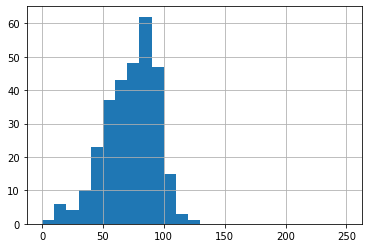

In [14]:
bin_range = np.arange(0, 260, 10)
df["Tweet_bersih"].str.len().hist(bins=bin_range);

2. Total word frequency distribution in each tweet

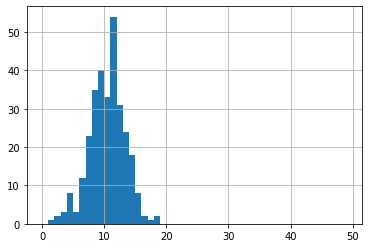

In [15]:
bin_range = np.arange(0, 50)
df["Tweet_bersih"].str.split().map(lambda sentence: len(sentence)).hist(bins=bin_range);

3. Length of word frequency distribution in each tweet

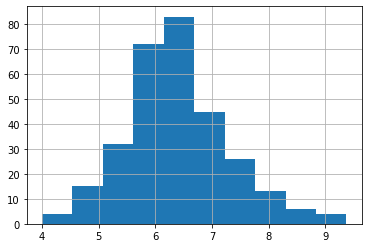

In [16]:
df["Tweet_bersih"].str.split().apply(
    lambda sentence: [len(word) for word in sentence]).map(lambda x: np.mean(x)).hist();

### Topic Analysis

Analyzing the most suitable topics for our data. Topic analysis is done using Latent Dirichlet Allocation (LDA) method. LDA method assumed there is coherency between our data and particular topics.

In [3]:
data_tweet = [tweet.split() for tweet in df["Tweet_bersih"]]
dictionary = corpora.Dictionary(data_tweet)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_tweet]

Building early model.

In [4]:
k = 5   # we randomly limit to 5 topics
model_LDA = LdaModel(random_state=100,
                     chunksize=100,
                     per_word_topics=True,
                     corpus=doc_term_matrix,
                     num_topics=k,
                     id2word = dictionary,
                     passes=50)

In [5]:
pprint(model_LDA.print_topics())

[(0,
  '0.077*"negara" + 0.075*"kota" + 0.024*"pindah" + 0.023*"kalimantan" + '
  '0.021*"nusantara" + 0.020*"indonesia" + 0.017*"nama" + 0.015*"uu" + '
  '0.015*"ikn" + 0.013*"timur"'),
 (1,
  '0.078*"negara" + 0.077*"kota" + 0.039*"ikn" + 0.037*"jakarta" + '
  '0.030*"pembangunan" + 0.020*"kalimantan" + 0.019*"tol" + 0.014*"salah" + '
  '0.014*"indonesia" + 0.014*"nusantara"'),
 (2,
  '0.056*"kota" + 0.048*"negara" + 0.019*"edy" + 0.019*"mulyadi" + '
  '0.018*"nusantara" + 0.017*"otorita" + 0.016*"pemindahan" + 0.014*"gt" + '
  '0.014*"ikn" + 0.012*"kamil"'),
 (3,
  '0.034*"kota" + 0.033*"negara" + 0.025*"tidak" + 0.018*"kepala" + '
  '0.015*"jokowi" + 0.014*"sudah" + 0.014*"presiden" + 0.014*"pemindahan" + '
  '0.012*"calon" + 0.012*"jangan"'),
 (4,
  '0.043*"negara" + 0.039*"kota" + 0.020*"tidak" + 0.016*"undang" + '
  '0.013*"dpr" + 0.011*"nusantara" + 0.011*"terima" + 0.010*"jakarta" + '
  '0.010*"kasih" + 0.009*"anggota"')]


Now we calculate the Coherence value. Coherence value/score represents coherency of each word to particular topics.

In [6]:
coherence_model_LDA = CoherenceModel(model=model_LDA,
                                     texts=data_tweet,
                                     dictionary=dictionary,
                                     coherence="c_v")

coherence_LDA = coherence_model_LDA.get_coherence()
print("Skor Coherence: ", coherence_LDA)


Skor Coherence:  0.4311829363183409


This score can still be optimized, hence we will do Hyperparameter Tuning. Let's define a function to automatically building model and calculate coherence value.

In [7]:
def compute_coherence_values(corpus, dictionary, k, a, b, data):
    model_LDA = LdaMulticore(corpus=doc_term_matrix,
                             id2word=dictionary,
                             num_topics=k, 
                             random_state=100,
                             chunksize=100,
                             passes=10,
                             alpha=a,
                             eta=b)
    
    coherence_model_LDA = CoherenceModel(model=model_LDA,
                                         texts=data,
                                         dictionary=dictionary,
                                         coherence="c_v")
    return coherence_model_LDA.get_coherence()

Define the parameters and its values to find the optimal value.

In [12]:
# Topic (k)
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha (a)
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append("symmetric")
alpha.append("asymmetric")

# Beta (b)
beta = list(np.arange(0.01, 1, 0.3))
beta.append("symmetric")

# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [ClippedCorpus(doc_term_matrix, num_of_docs*0.75), doc_term_matrix]
corpus_title = ["75% Corpus", "100% Corpus"]

model_results = {"Validation_Set": [],
                 "Topics": [],
                 "Alpha": [],
                 "Beta": [],
                 "Coherence": []}

Now let's start the hyperparameter tuning. Tqdm module is used to track processing progress.

In [14]:
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    for i in range(len(corpus_sets)):
        for k in topics_range:
            for a in alpha:
                for b in beta:
                    cv = compute_coherence_values(corpus=corpus_sets[i],
                                                  dictionary=dictionary, 
                                                  k=k,
                                                  a=a,
                                                  b=b,
                                                  data=data_tweet)
                    
                    model_results["Validation_Set"].append(corpus_title[i])
                    model_results["Topics"].append(k)
                    model_results["Alpha"].append(a)
                    model_results["Beta"].append(b)
                    model_results["Coherence"].append(cv)
                    
                    pbar.update(1)

    pd.DataFrame(model_results).to_csv("Hasil_Tuning_LDA.csv", index=False)
    pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [2:33:23<00:00, 17.04s/it]


In [15]:
df_tuning = pd.read_csv("Hasil_Tuning_LDA.csv")
df_tuning.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.389970
1,75% Corpus,2,0.01,0.31,0.404843
2,75% Corpus,2,0.01,0.61,0.404843
3,75% Corpus,2,0.01,0.9099999999999999,0.404843
4,75% Corpus,2,0.01,symmetric,0.404843


Next, we plot the coherence values to determine the optimal number of topics.

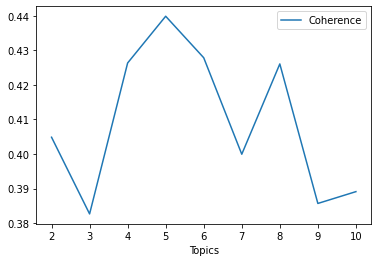

In [16]:
df_cv = df_tuning[(df_tuning.Alpha == "0.01") & (df_tuning.Beta == "0.31") & (df_tuning.Validation_Set == "100% Corpus")].copy()
df_cv.plot(x="Topics", y="Coherence", kind="line");

The highest coherence value indicates the optimal number of topics, so in this case we got 5 topics. Now we will use this k value to get optimal alpha and beta value.

In [17]:
k = 5
df_cv_2 = df_tuning[(df_tuning.Topics == k) & (df_tuning.Validation_Set == "100% Corpus")].copy()
df_cv_2.sort_values(by="Coherence", ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
361,100% Corpus,5,0.01,0.31,0.439837
362,100% Corpus,5,0.01,0.61,0.434188
364,100% Corpus,5,0.01,symmetric,0.427824
368,100% Corpus,5,0.31,0.9099999999999999,0.415510
383,100% Corpus,5,symmetric,0.9099999999999999,0.414607
380,100% Corpus,5,symmetric,0.01,0.414321
363,100% Corpus,5,0.01,0.9099999999999999,0.413918
375,100% Corpus,5,0.9099999999999999,0.01,0.411986
382,100% Corpus,5,symmetric,0.61,0.411174
384,100% Corpus,5,symmetric,symmetric,0.409533


The highest coherence value indicates the optimal alpha and beta value, so in this case we got 0.01 and 0.31 for those parameters. Finally, input those optimized parameters to our model to predict the topics.

In [25]:
a = 0.01
b = 0.31
model_LDA = LdaMulticore(corpus=doc_term_matrix,
                         id2word=dictionary,
                         num_topics=k,
                         random_state=100,
                         chunksize=100,
                         passes=10,
                         alpha=a,
                         eta=b)

pprint(model_LDA.print_topics())

[(0,
  '0.064*"kota" + 0.053*"negara" + 0.024*"nusantara" + 0.013*"kalimantan" + '
  '0.013*"ikn" + 0.012*"pemindahan" + 0.012*"nama" + 0.009*"gt" + '
  '0.008*"indonesia" + 0.007*"timur"'),
 (1,
  '0.061*"negara" + 0.054*"kota" + 0.030*"ikn" + 0.018*"kalimantan" + '
  '0.016*"pembangunan" + 0.014*"tol" + 0.012*"undang" + 0.011*"pindah" + '
  '0.011*"jakarta" + 0.010*"nusantara"'),
 (2,
  '0.044*"kota" + 0.042*"negara" + 0.015*"edy" + 0.013*"mulyadi" + '
  '0.009*"jakarta" + 0.009*"daerah" + 0.009*"pemindahan" + 0.007*"indonesia" + '
  '0.007*"khusus" + 0.007*"kalimantan"'),
 (3,
  '0.047*"kota" + 0.043*"negara" + 0.017*"tidak" + 0.014*"ikn" + '
  '0.013*"pemindahan" + 0.012*"jakarta" + 0.009*"indonesia" + 0.009*"uu" + '
  '0.007*"wilayah" + 0.007*"pindah"'),
 (4,
  '0.048*"negara" + 0.042*"kota" + 0.017*"nusantara" + 0.017*"tidak" + '
  '0.013*"kalimantan" + 0.013*"nama" + 0.012*"ikn" + 0.009*"undang" + '
  '0.009*"presiden" + 0.009*"kamil"')]


### Sentiment Analysis

Before we begin the sentiment analysis, we must transform our text data into numerical data (vectorization) in order to the machine learning model able to process our data set. For this transformation, we are going to use Term Frequency-Inverse Document Frequency (TF-IDF) method.

In [7]:
vectorizer = TfidfVectorizer(max_features=2500)

Machine learning model that used in this case is (Gaussian) Navie Bayes.

In [8]:
model_GNB = GaussianNB()

Convert Sentiment feature value in our training data set, "positive" and "negative" into "1" and "0".

In [9]:
df_train.replace({"Sentiment":{"negative":0, "positive":1}}, inplace=True)
df_train

,Sentiment,Teks,Teks_bersih
0,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,tolol tidak hubungan keguguran dipakai hijab s...
1,0,Geblek lo tata...cowo bgt dibela2in balikan......,bodoh tata cowo bgt dibela balikan hadeww ntar...
2,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kemarin termewek lengket duhhh labil bgt terim...
3,0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kesal att tidak anaknya kasian perkemb...
4,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadewwwww permpuan sakit jiwa peran utama film...
...,...,...,...
395,1,Bangga sama suami yg selalu ingat istri disela...,bangga suami istri disela apapun profesimu kau...
396,1,Apaoun pekerjaannya yg penting halal u tuk men...,apapun pekerjaannya halal halus mengantuk mena...
397,1,Gojek itu mayoritas pegangguran yang lama gak ...,gojek mayoritas pegangguran tidak kerja putus ...
398,1,<USERNAME> aslinya cantik dan ayu loh mbak kr...,aslinya cantik ayu menembak sudah bertemu lang...


Let's vectorize our training data set.

In [10]:
vector_data = vectorizer.fit_transform(df_train["Teks_bersih"]).toarray()
vectorizer.fit_transform(df_train["Teks_bersih"])

<400x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 5432 stored elements in Compressed Sparse Row format>

Now we split our training data set into train and test data, fit the model, then calculate:
- Confusion matrix
- Classification report
- Accuracy score

to see the model performance.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(vector_data,
                                                    df_train["Sentiment"],
                                                    test_size=0.2,
                                                    random_state=52)

model_GNB.fit(X_train, y_train)
y_preds = model_GNB.predict(X_test)

print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))
print("Skor akurasi: ", accuracy_score(y_test, y_preds))

[[35  5]
 [ 7 33]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        40
           1       0.87      0.82      0.85        40

    accuracy                           0.85        80
   macro avg       0.85      0.85      0.85        80
weighted avg       0.85      0.85      0.85        80

Skor akurasi:  0.85


Those performance scores are good enough to verify that our model is can be used for prediction/classification. Now, let's predict.

In [13]:
vector_tweet = vectorizer.transform(df["Tweet_bersih"]).toarray()
y_classification = model_GNB.predict(vector_tweet)

df["Sentimen"] = list(y_classification)
df

,Created At,Tweet,Tweet_bersih,Sentimen
0,2022-01-26 23:56:45+00:00,Gak kredibel tapi jadi menteri. \nMakin memper...,tidak kredibel menteri memperburuk citra pemer...,1
1,2022-01-26 23:30:27+00:00,"@democrazymedia Woi, ibu kota itu salah 1 bag...",kota salah negara tidak diumbar pembangunannya...,1
2,2022-01-26 22:47:31+00:00,Kantor Staf Presiden (KSP) memastikan skema pe...,kantor staf presiden ksp skema pembiayaan pemb...,0
3,2022-01-26 22:01:40+00:00,Pembangunan ibu kota negara (IKN0 membawa manf...,pembangunan kota negara ikn membawa manfaat pe...,0
4,2022-01-26 22:01:39+00:00,Pembangunan ibu kota negara (IKN0 membawa manf...,pembangunan kota negara ikn membawa manfaat pe...,0
...,...,...,...,...
295,2022-01-23 03:28:46+00:00,"Ibu Kota Negara Pindah ke Kaltim, Anies Yakin ...",kota negara pindah kaltim anies jakarta pusat ...,1
296,2022-01-23 03:22:56+00:00,5 Negara Ini Dinilai Gagal Memindahkan Ibu Kot...,negara dinilai gagal memindahkan kota pegawain...,1
297,2022-01-23 03:00:08+00:00,"UU Ibu Kota Negara Bisa Dibatalkan MK, Ini Ala...",uu kota negara dibatalkan mk alasannya,0
298,2022-01-23 02:56:05+00:00,"Disahkan DPR, Faisal Basri akan Gugat UU Ibu K...",disahkan dpr faisal basri gugat uu kota negara mk,0


Export our classified data set to CSV file.

In [14]:
df.to_csv("IKN_Tweet_Sentiment.csv", index=False)

##### Bi-gram Distribution Analysis

Bi-gram Distribution is a text analysis method that combines every 2 words to a single group. We will use Bi-gram distribution to analyse positive and negative tweets.

In [15]:
# Positive sentiment
df_pos = df[df["Sentimen"] == 1]["Tweet_bersih"]
tweet_pos = [word for tweet in df_pos for word in tweet.split()]

bi_gram_pos = pd.Series(ngrams(tweet_pos, 2)).value_counts()
bi_gram_pos[:10]

(kota, negara)        46
(negara, pindah)      10
(dki, jakarta)         7
(negara, ikn)          7
(ridwan, kamil)        7
(terima, kasih)        7
(pindah, kota)         7
(pemindahan, kota)     6
(undang, undang)       6
(presiden, jokowi)     4
dtype: int64

In [16]:
# Negative sentiment
df_neg = df[df["Sentimen"] == 0]["Tweet_bersih"]
tweet_neg = [word for tweet in df_neg for word in tweet.split()]

bi_gram_neg = pd.Series(ngrams(tweet_neg, 2)).value_counts()
bi_gram_neg[:10]

(kota, negara)         147
(negara, ikn)           41
(pemindahan, kota)      24
(kalimantan, timur)     21
(edy, mulyadi)          16
(pembangunan, kota)     15
(negara, nusantara)     14
(otorita, kota)          9
(ikn, nusantara)         9
(uu, kota)               9
dtype: int64

Last but not least, we calculate the percentage for each sentiment.

In [20]:
print(f"Persentase sentimen positif: {(100*len(df_pos)/len(df)):.1f}%")
print(f"Persentase sentimen negatif: {(100*len(df_neg)/len(df)):.1f}%")

Persentase sentimen positif: 36.7%
Persentase sentimen negatif: 63.3%


## Data Analysis

##### Text Analysis

Based on the text analysis result, insights that can be obtained from DKI Jakarta resident tweets about Indonesia capital city transfer to Penajam Paser Utara, East Kalimantan is the total character per tweet are around 80-100 characters. Then, each tweet consists of an average of 9-12 words where each word is composed of 6-7 characters. Furthermore, the 3 most frequent mentioned words in DKI Jakarta resident tweets about this issue are "nusantara", "kalimantan", dan "tidak".

##### Topic Analysis

Based on the topic analysis result, we got 5 optimal number of topics. Here is the explanation:
1. The first topic (index 0) is about the new capital city name polemic which called "Nusantara" which was announced by the Minister of National Development Planning/Head of Bappenas and approved by the President of the Republic of Indonesia.
2. The second topic (index 1) is about the access road to the new capital city in East Kalimantan, which is an underwater toll road (submersible crossing) that planned to connect with existing Balikpapan-Samarinda toll road.
3. The third topic (index 2) is about Edy Mulyadi case; a viral video in social media which showing him insulting the new capital city location, Kalimantan.
4. The fourth topic (index 3) is about the ratification of the new capital city constitution in DPR RI plenary meeting, which assure the capital city transfer from DKI Jakarta to East Kalimantan.
5. The fifth topic (index 4) is about the President of the Republic of Indonesia stated that 2 main criteria of the new capital city head of authority are experienced in leading a territory and has architect background. One of the people that meet these criteria is Ridwan Kamil.

##### Sentiment Analysis

Based on the sentiment analysis result, insights that can be obtained from DKI Jakarta resident tweets about Indonesia capital city transfer to Penajam Paser Utara, East Kalimantan are the percentage of positive sentiment tweets are around 36.7%, whilst the percentage of negative sentiment tweets are around 63.3%.

Ideally, on a policy released by the government, the public sentiment is positive, however in this issue the fact says otherwise. This could be means that the majority of the public are still disagreeing with the policy, hence this must become a concern for the government to do socialization or policy reassessment if when the time comes to implement the policy, they want everything runs smoothly and supported by all levels of society.

Based on the Bi-gram distribution analysis result, insights that can be obtained are the positive sentiment tweets mostly discussed DKI Jakarta fate after the capital city is transferred. Whereas the negative sentiment tweets mostly discussed the public skepticism of the new capital city constitution and policy.

##### Conclusion

Based on the 3 analysis above, here is the answer of the questions in the business understanding section:
1. Does DKI Jakarta resident agree or disagree to transfer the capital city to Penajam Paser Utara, East Kalimantan?
> About 63% or 2/3 of DKI Jakarta resident are still disagreeing to transfer the capital city to East Kalimantan.
2. What is the reason or cause of their agreement/disagreement?
> The disagreement exists because of 2 reasons. First, they are still questioning how DKI Jakarta fate after "left away". Second, they still skeptic to the new capital city constitution and policy.

*The term "DKI Jakarta resident" mentioned in this micro project is DKI Jakarta resident that use Twitter.*